In [56]:
# This code block imports all the libraries we need, saves all the functions, and
# reads data from CSV and prepares it for analysis

# IMPORT NECESSARY LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
import math
from scipy import optimize

import pandas as pd
import urllib.request

def downDataIntoCleanRows():
    # Download the global confirmed cases CSV file from the John's Hopkins Github repository and save to a clean dataframe
    url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_global.csv'
    filename = 'time_series_covid19_confirmed_global.csv'     # filename for the file AFTER we save it
    urllib.request.urlretrieve(url, filename)     # command to download the file
    confirmed = cleanCSV(filename)

    # Download the global recovered cases CSV file from the John's Hopkins Github repository and save to a clean dataframe
    url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_recovered_global.csv'
    filename = 'time_series_covid19_recovered_global.csv'
    urllib.request.urlretrieve(url, filename)
    recovered = cleanCSV(filename)

    # Download the global deaths CSV file from the John's Hopkins Github repository and save to a clean dataframe
    url = 'https://github.com/CSSEGISandData/COVID-19/raw/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_deaths_global.csv'
    filename = 'time_series_covid19_deaths_global.csv'
    urllib.request.urlretrieve(url, filename)
    deaths = cleanCSV(filename)

    return confirmed, recovered, deaths

def cleanCSV(filename):
    # Read the CSV file into a Pandas dataframe
    dataFrame = pd.read_csv(filename)

    # Replace slashes with _ in the header (cleaning the data)
    dataFrame.columns = [column.replace('/','_') for column in dataFrame.columns]

    return dataFrame

def queryForCountry(confirmed, recovered, deaths, countryName):
    # Find data from the specified country
    confirmed = confirmed.query('Country_Region == @countryName')
    recovered = recovered.query('Country_Region == @countryName')
    deaths = deaths.query('Country_Region == @countryName')

    # Drop columns that we don't need (for comparison with SIR models)
    confirmed = confirmed.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)
    recovered = recovered.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)
    deaths = deaths.drop(['Province_State', 'Country_Region', 'Lat', 'Long'], axis=1)

    # Convert these dataframes to NumPy
    confirmed = confirmed.to_numpy()[0]
    recovered = recovered.to_numpy()[0]
    deaths = deaths.to_numpy()[0]

    # Read the CSV file for populations
    populations = pd.read_csv('WorldBankPopulation2018.csv')

    # Drop columns we don't need
    populations = populations.drop(['Country_Code'], axis=1)

    # Query the populations for the country we chose
    populations = populations.query('Country_Name == @countryName')

    # Convert dataframe to NumPy and choose the value in column 1 (population)
    countryPopulation = populations.to_numpy()[0][1]

    R = recovered + deaths
    I = confirmed - R
    S = countryPopulation - confirmed

    firstCase = np.nonzero(I)[0][0] + 10

    S = S[firstCase:]
    I = I[firstCase:]
    R = R[firstCase:]

    data = np.vstack((S,I,R))

    data = np.array(list(data[:,:]), dtype=np.float64)

    return data

In [210]:
## SIMULATIONS
#
# Simulate the SIR model if we know alpha, beta, S0, I0, R0
def sirBasic(S0, I0, R0, alpha, beta, n):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIR = np.zeros((3,n+1))
    totalInfected = 0

    # fill in the initial data
    SIR[:,0] = np.array([S0, I0, R0])

    for i in range(n):
        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i],
                                          beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i],
                                          alpha*SIR[1,i]])

        totalInfected += beta*SIR[0,i]*SIR[1,i]

    return SIR, totalInfected

# Simulate the SIR model when we vaccinate v people per day starting on day m with probability of success p
def sirVaccine(S0, I0, R0, alpha, beta, n, v, m, p):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIR = np.zeros((3,n+1))
    vaccines = 0
    totalVaccinated = 0
    totalInfected = 0

    # fill in the initial data
    SIR[:,0] = np.array([S0, I0, R0])

    for i in range(n):
        if i >= m:
            vaccines = p*min(v,SIR[0,i])
            totalVaccinated += v

        SIR[:,i+1] = SIR[:,i] + np.array([-beta*(SIR[0,i] - vaccines) * SIR[1,i] - vaccines,
                                          beta * (SIR[0,i] - vaccines) * SIR[1,i] - alpha * SIR[1,i],
                                          alpha * SIR[1,i] + vaccines])

        totalInfected += beta*(SIR[0,i] - vaccines)*SIR[1,i]

    return SIR, totalInfected, totalVaccinated

# Advanced SIR Model

# Sigmoid function
def sigmoid(t):
    return 1/(1+np.exp(-t))

# Advanced SIR simulation
def sirAdvanced(S0, I0, R0, alpha1, alpha2, beta1, beta2, n1, m1, k, j, n):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIR = np.zeros((3,n+1))
    totalInfected = 0

    # fill in the initial data
    SIR[:,0] = np.array([S0, I0, R0])

    for i in range(n):
        # update alpha
        alpha = (alpha2 - alpha1)*sigmoid(k*(i - n1)) + alpha1

        # update beta
        beta = (beta2 - beta1)*sigmoid(j*(i - m1)) + beta1

        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i], beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i], alpha*SIR[1,i]])
        totalInfected += beta*SIR[0,i]*SIR[1,i]

    return SIR, totalInfected

# Advanced SIR simulation with vaccines
def sirAdvancedVaccine(S0, I0, R0, alpha1, alpha2, beta1, beta2, n1, m1, k, j, n, v, m, p):
    # Make an empty 3 by 101 matrix that will be the predicted number of people in each group
    SIR = np.zeros((3,n+1))
    vaccines = 0
    totalVaccinated = 0
    totalInfected = 0

    # fill in the initial data
    SIR[:,0] = np.array([S0, I0, R0])

    for i in range(n):
        # if time >= m, give vaccines!
        if i >= m:
            vaccines = p*min(v,SIR[0,i])
            totalVaccinated += v

        # update alpha
        alpha = (alpha2 - alpha1)*sigmoid(k*(i - n1)) + alpha1

        # update beta
        beta = (beta2 - beta1)*sigmoid(j*(i - m1)) + beta1

        SIR[:,i+1] = SIR[:,i] + np.array([-beta*SIR[0,i]*SIR[1,i] - vaccines,
                                          beta*SIR[0,i]*SIR[1,i] - alpha*SIR[1,i],
                                          alpha*SIR[1,i] + vaccines])

        totalInfected += beta*SIR[0,i]*SIR[1,i]

    return SIR, totalInfected, totalVaccinated

# Function that computes the error between simulated data and real data
def findError(data, simulated):
    return math.sqrt(np.sum((data - simulated)**2))

In [211]:
## DATA PREPARATION AND READING FROM CSV

confirmed, recovered, deaths = downDataIntoCleanRows()
data = queryForCountry(confirmed, recovered, deaths, 'US')

# Pull initial data values from the real data
S0 = data[0,0]
I0 = data[1,0]
R0 = data[2,0]

lastDay = data.shape[1] - 1

In [212]:
# this is ERR(alpha,b)
# Basic Model
# x = [x[0], x[1]] = (alpha, b)
f = lambda x: findError(sirBasic(S0,I0,R0,x[0],x[1]/S0,lastDay)[0], data)

# Advanced Model
# x = [x[0], x[1], x[2], x[3], x[4], x[5], x[6], x[7]] = (alpha1, alpha2, beta1, beta2, n1, m1, k, j)
#f = lambda x: findError(sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],lastDay)[0], data)

# Run the optimization code (multidimensional gradient descent) to find the best parameters for ths model
# to fit to the data. (This solves for *all* parameters at one time!)

result = optimize.minimize(f, [0.1, 0.2], bounds = ((0,1), (0,1)))
#result = optimize.minimize(f, [0.1, 0.1, 0.2, 0.2, lastDay/2, lastDay/2, 1, 1],
#                           bounds=((0,1),(0,1),(0,1),(0,1),(0,lastDay),(0,lastDay),(-4,4),(-4,4)))

print(result)

x = result.x

      fun: 15858043.81059011
 hess_inv: <2x2 LbfgsInvHessProduct with dtype=float64>
      jac: array([400.84123605, 267.8483726 ])
  message: b'CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH'
     nfev: 240
      nit: 30
     njev: 80
   status: 0
  success: True
        x: array([0.04818182, 0.13003114])


Without vaccines, 300072404.15680164  people were infected


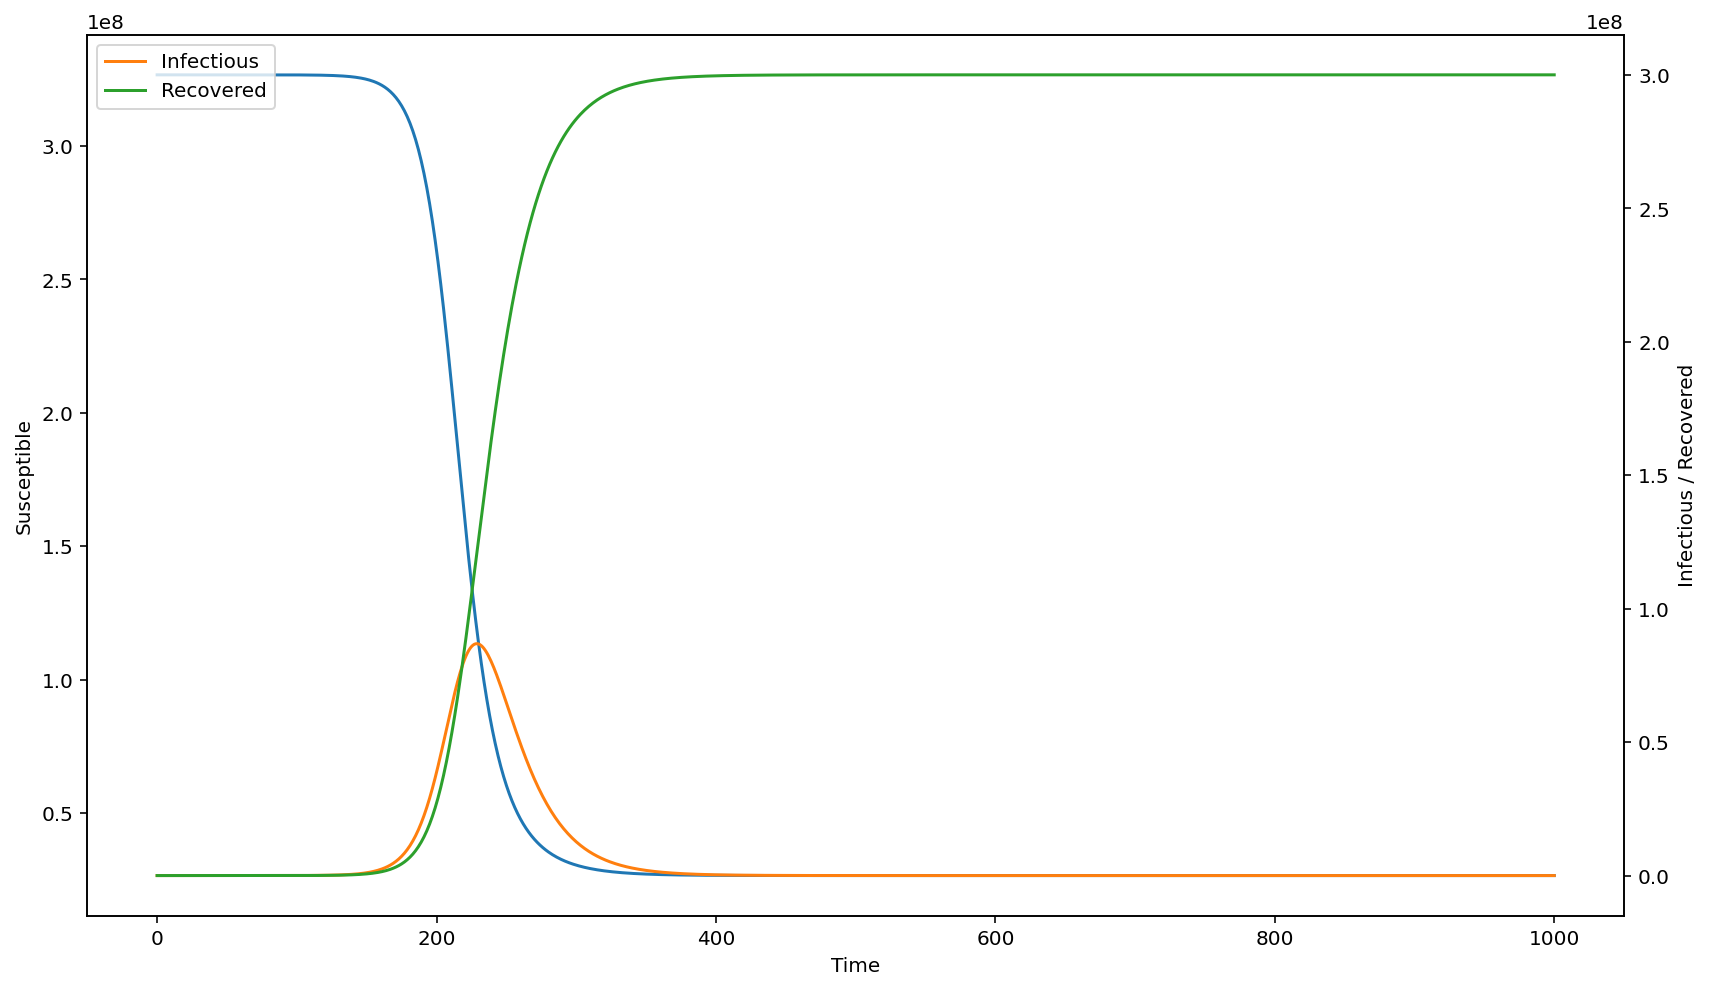

In [213]:
n = 1000
simulated, totalInfected = sirBasic(S0,I0,R0,x[0],x[1]/S0,n)
#simulated, totalInfected = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

fig, ax1 = plt.subplots()

ax1.set_xlabel('Time')
ax1.set_ylabel('Susceptible')
ax1.plot(simulated[0,:],color='tab:blue',label='Susceptible')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Infectious / Recovered')  # we already handled the x-label with ax1
ax2.plot(simulated[1,:],color='tab:orange',label='Infectious')
ax2.plot(simulated[2,:],color='tab:green',label='Recovered')
ax2.tick_params(axis='y')

#ax1.plot(data[0,:],'.',color='tab:blue',label='S data')
#ax2.plot(data[1,:],'.',color='tab:orange',label='I data')
#ax2.plot(data[2,:],'.',color='tab:green',label='S data')

#ax1.ticklabel_format(useOffset=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()

print('Without vaccines,', totalInfected, ' people were infected')

# Plot the simulated data with vaccines
#vaccines, totalInfectedwithVaccinations, totalVaccinated = sirBasicVaccine(S0,I0,R0,x[0],x[1]/S0,n,10000,20,0.8)

#print('With vaccines,', totalInfectedwithVaccinations, ' people were infected')

#print(totalInfected - totalInfectedwithVaccinations, 'is the number of fewer cases with a total of', totalVaccinated, 'vaccines given')

#plt.plot(vaccines[0,:], '--', label='Vax S')
#plt.plot(vaccines[1,:], '--', label='Vax I')
#plt.plot(vaccines[2,:], '--', label='Vax R')

# Reset the colors
#plt.gca().set_prop_cycle(None)

# Plot the real data as dots
#plt.plot(data[0,:], '.', label='S data')
#plt.plot(data[1,:], '.', label='I data')
#plt.plot(data[2,:], '.', label='R data')

plt.legend()

Without vaccines, 300072404.15680164  people were infected
With vaccines, 265355288.31641904  people were infected
34717115.840382606 is the number of fewer cases with a total of 80000000 vaccines given


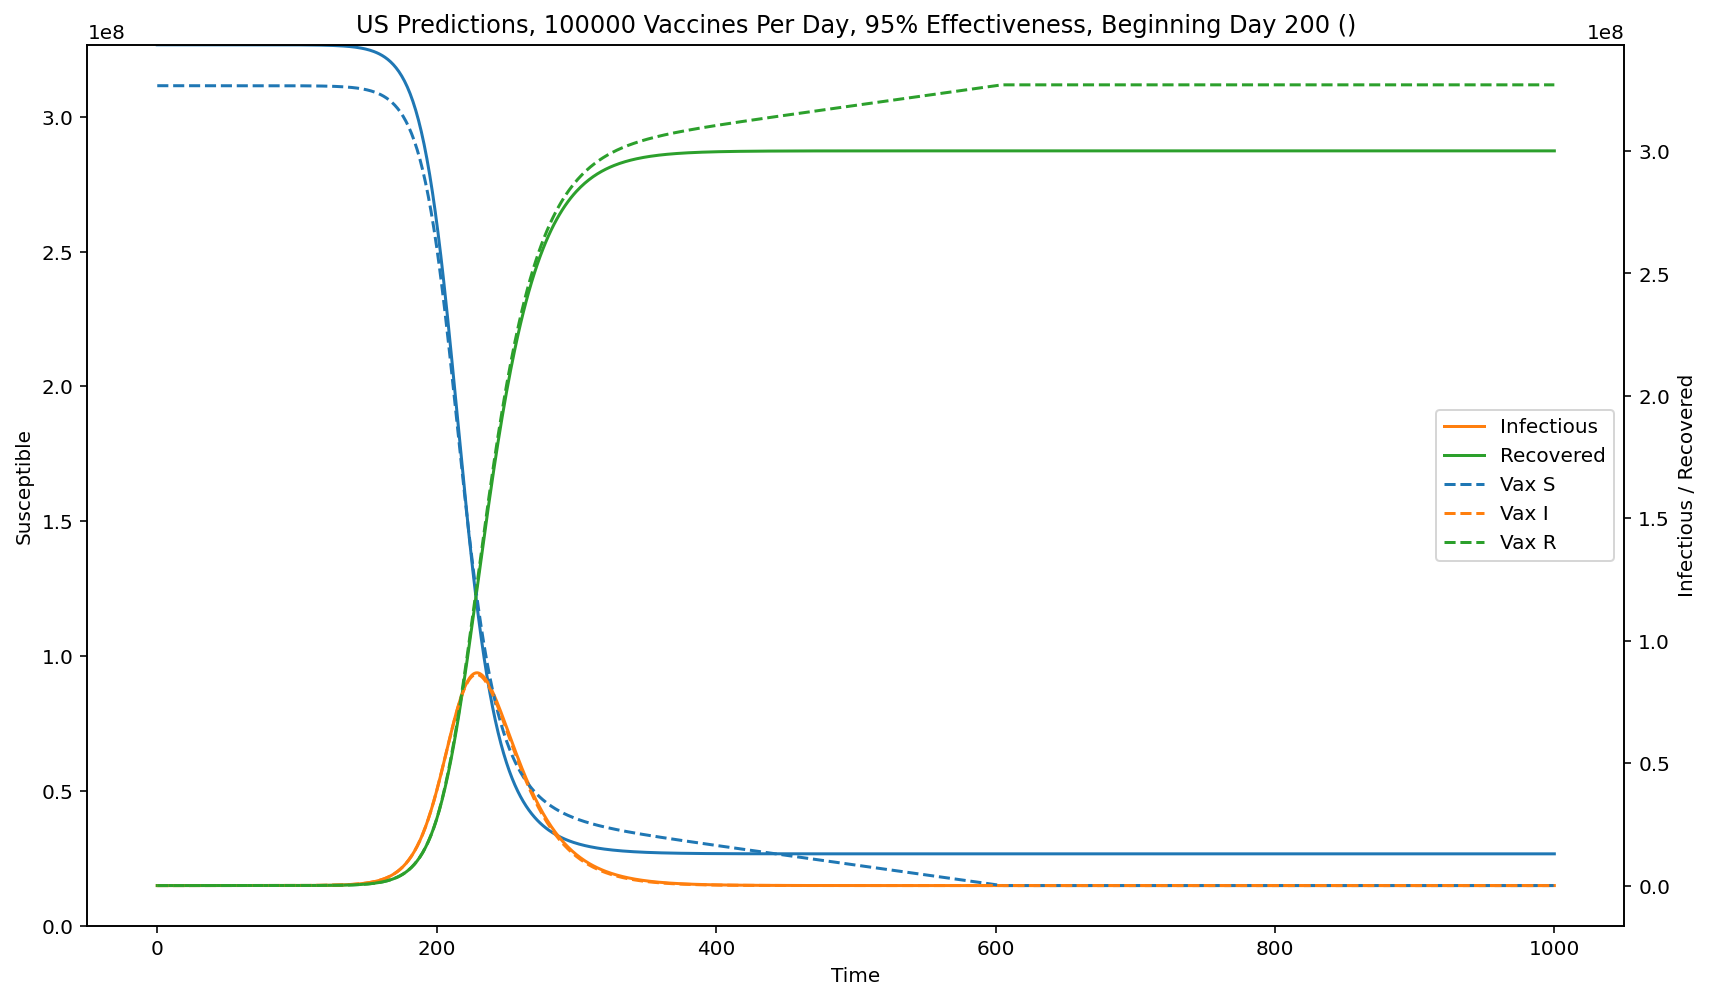

In [214]:
n = 1000
simulated, totalInfected = sirBasic(S0,I0,R0,x[0],x[1]/S0,n)
#simulated, totalInfected = sirAdvanced(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n)

fig, ax1 = plt.subplots()
ax1.set_ylim(0, max(simulated[0,:]))
ax2.set_ylim(0, max(simulated[2,:]))

ax1.set_xlabel('Time')
ax1.set_ylabel('Susceptible')
ax1.plot(simulated[0,:],color='tab:blue',label='Susceptible')
ax1.tick_params(axis='y')

ax2 = ax1.twinx()  # instantiate a second axes that shares the same x-axis

ax2.set_ylabel('Infectious / Recovered')  # we already handled the x-label with ax1
ax2.plot(simulated[1,:],color='tab:orange',label='Infectious')
ax2.plot(simulated[2,:],color='tab:green',label='Recovered')
ax2.tick_params(axis='y')

#ax1.plot(data[0,:],'.',color='tab:blue',label='S data')
#ax2.plot(data[1,:],'.',color='tab:orange',label='I data')
#ax2.plot(data[2,:],'.',color='tab:green',label='S data')

#ax1.ticklabel_format(useOffset=False)

fig.tight_layout()  # otherwise the right y-label is slightly clipped
#plt.show()

print('Without vaccines,', totalInfected, ' people were infected')

# Plot the simulated data with vaccines
vaccines, totalInfectedwithVaccinations, totalVaccinated = sirBasicVaccine(S0,I0,R0,x[0],x[1]/S0,n,100000,200,0.8)
#vaccines, totalInfectedWithVaccinations, totalVaccinated = sirAdvancedVaccine(S0,I0,R0,x[0],x[1],x[2]/S0,x[3]/S0,x[4],x[5],x[6],x[7],n,10000,200,0.95)

print('With vaccines,', totalInfectedWithVaccinations, ' people were infected')

print(totalInfected - totalInfectedWithVaccinations, 'is the number of fewer cases with a total of', totalVaccinated, 'vaccines given')

plt.plot(vaccines[0,:], '--', label='Vax S')
plt.plot(vaccines[1,:], '--', label='Vax I')
plt.plot(vaccines[2,:], '--', label='Vax R')

# Reset the colors
plt.gca().set_prop_cycle(None)

# Plot the real data as dots
#plt.plot(data[0,:], '.', label='S data')
#plt.plot(data[1,:], '.', label='I data')
#plt.plot(data[2,:], '.', label='R data')

plt.title('US Predictions, 100000 Vaccines Per Day, 95% Effectiveness, Beginning Day 200 ()')
plt.legend()

Without vaccines, 300072404.15680164  people were infected
With vaccines, 265355288.31641904  people were infected
34717115.840382606 is the number of fewer cases with a total of 70000000 vaccines given


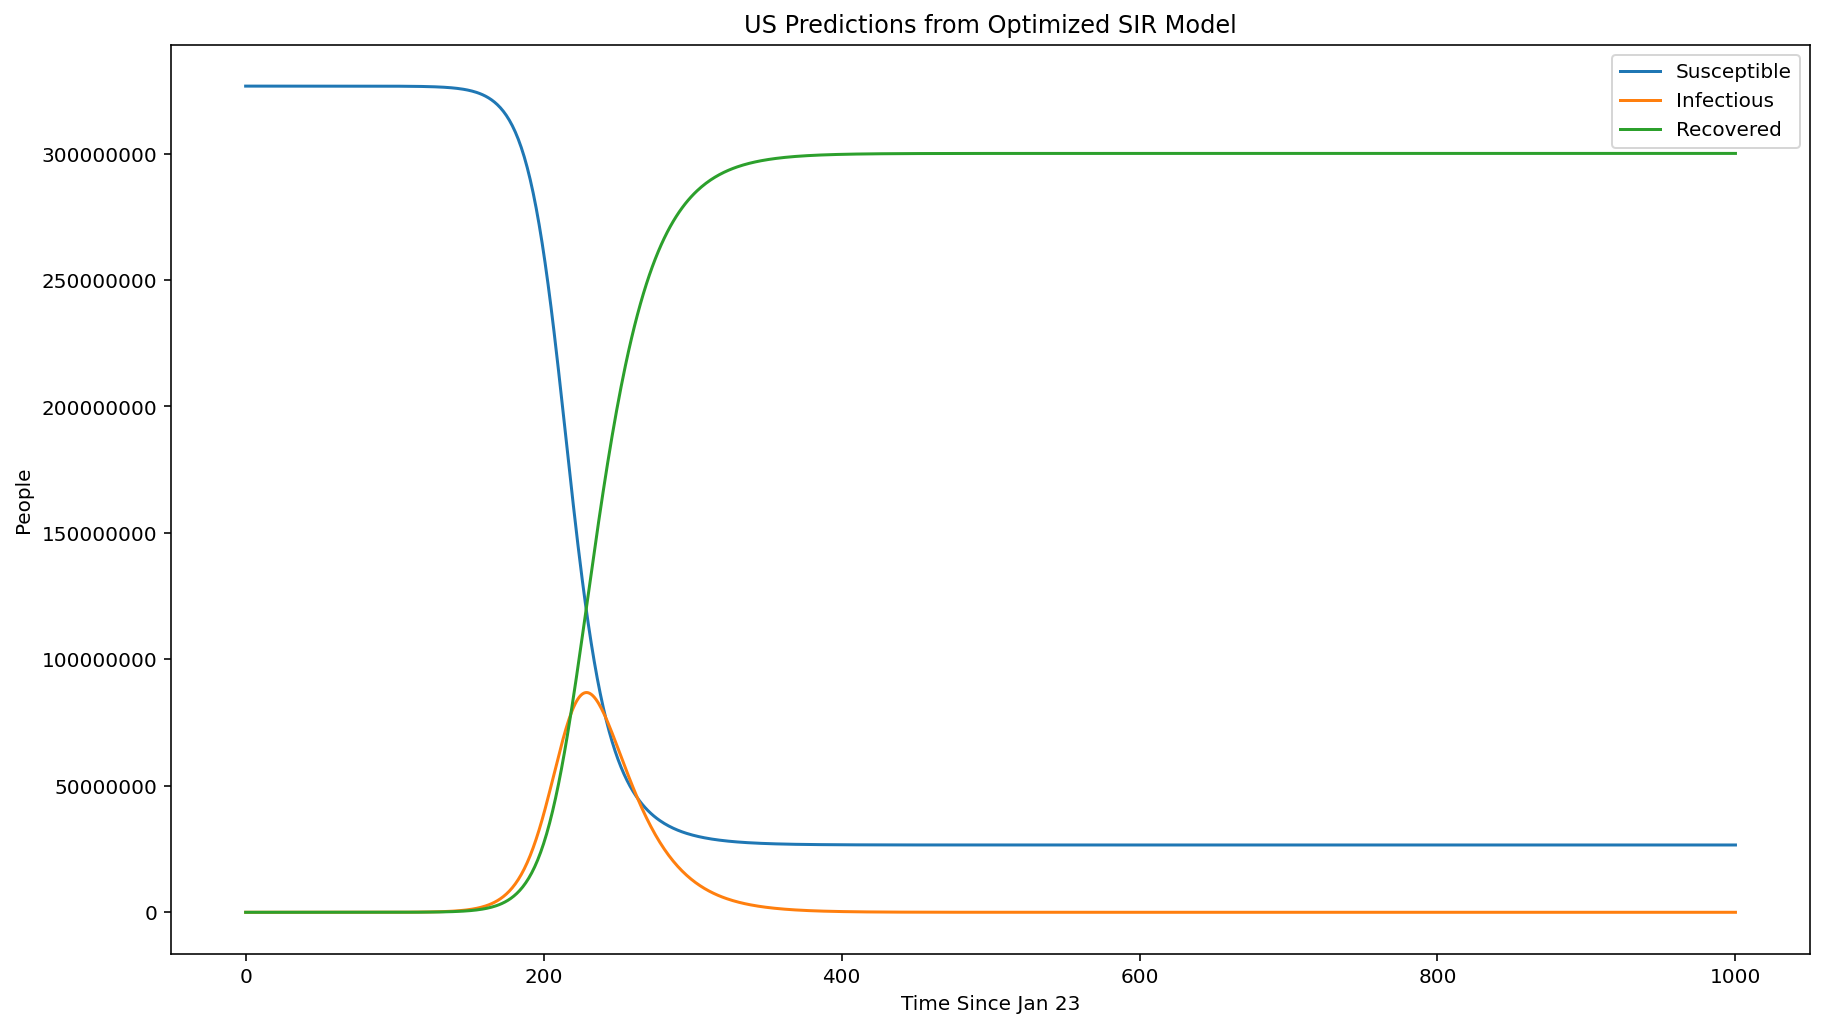

In [229]:
n = 1000
simulated, totalInfected = sirBasic(S0,I0,R0,x[0],x[1]/S0,n)

plt.plot(simulated[0,:],label='Susceptible')
plt.plot(simulated[1,:],label='Infectious')
plt.plot(simulated[2,:],label='Recovered')

# Reset the colors
plt.gca().set_prop_cycle(None)

plt.tight_layout()
plt.xlabel('Time Since Jan 23')
plt.ylabel('People')

# Plot the simulated data with vaccines
vaccines300, totalInfectedwithVaccinations, totalVaccinated = sirBasicVaccine(S0,I0,R0,x[0],x[1]/S0,n,100000,300,0.95)

#plt.plot(vaccines300[0,:], '--', label='Vax S')
#plt.plot(vaccines300[1,:], '--', label='Vax I')
#plt.plot(vaccines300[2,:], '--', label='Vax R')

plt.title('US Predictions from Optimized SIR Model')
#plt.title('US Predictions, 1000000 Vaccines Per Day, 95% Effectiveness, Beginning Day 300 (Nov 19, 2020)')
plt.legend()

plt.ticklabel_format(style='plain')

print('Without vaccines,', totalInfected, ' people were infected')
print('With vaccines,', totalInfectedWithVaccinations, ' people were infected')
print(totalInfected - totalInfectedWithVaccinations, 'is the number of fewer cases with a total of', totalVaccinated, 'vaccines given')

Text(0.5, 1.0, 'Reduction in Infectious People (starting Nov 19, 2020)')

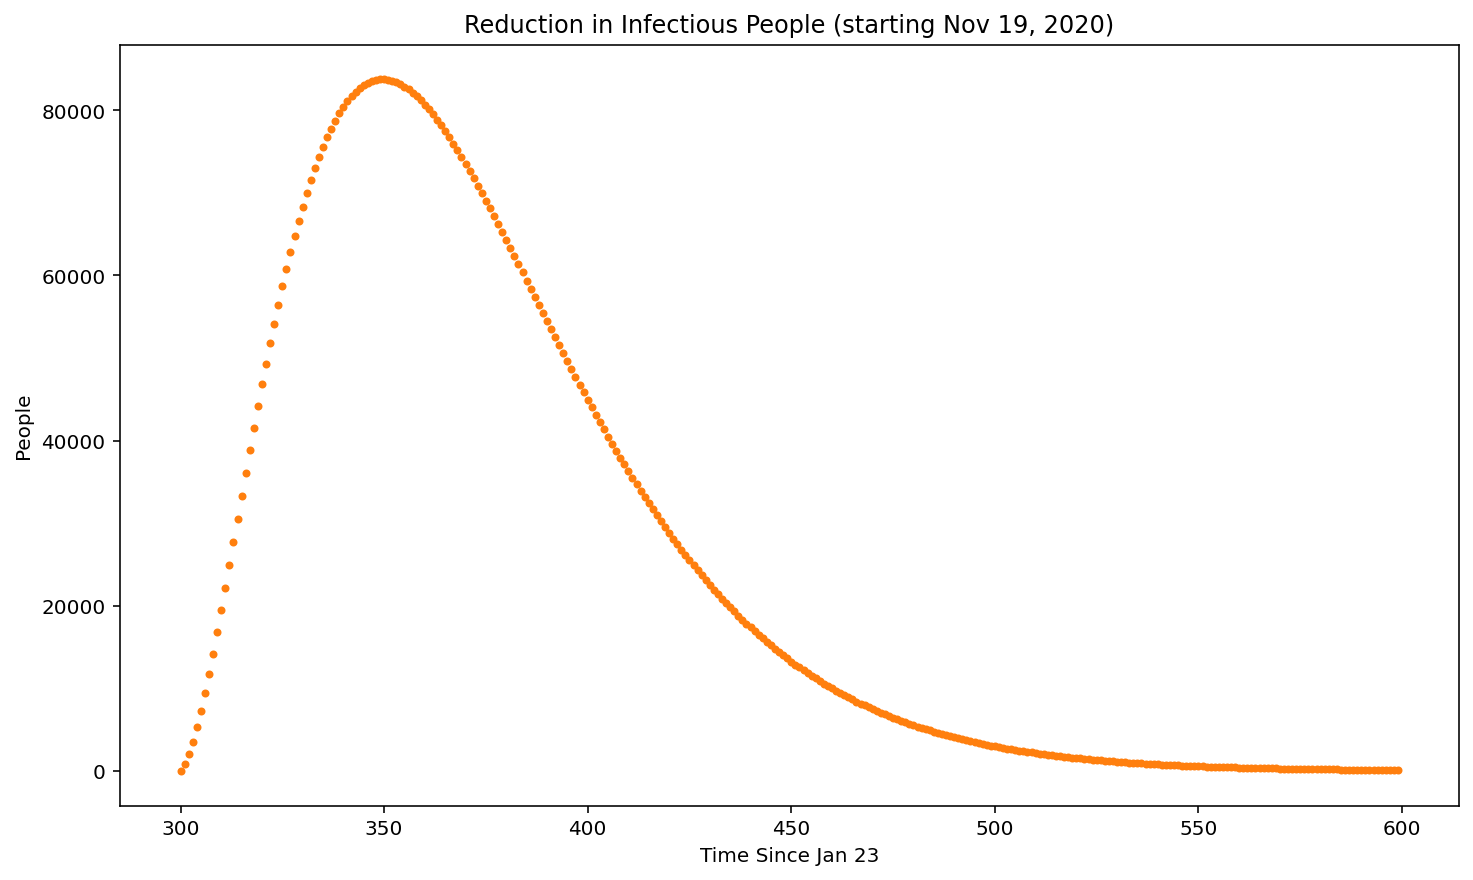

In [228]:
plt.plot(np.arange(300,600,1),simulated[1,303:603] - vaccines300[1,303:603], '.', color='tab:orange', label='Reduction in Infectious Cases')
#plt.legend()
plt.xlabel('Time Since Jan 23')
plt.ylabel('People')
plt.title('Reduction in Infectious People (starting Nov 19, 2020)')

Without vaccines, 300072404.15680164  people were infected
With vaccines, 265355288.31641904  people were infected
34717115.840382606 is the number of fewer cases with a total of 60000000 vaccines given


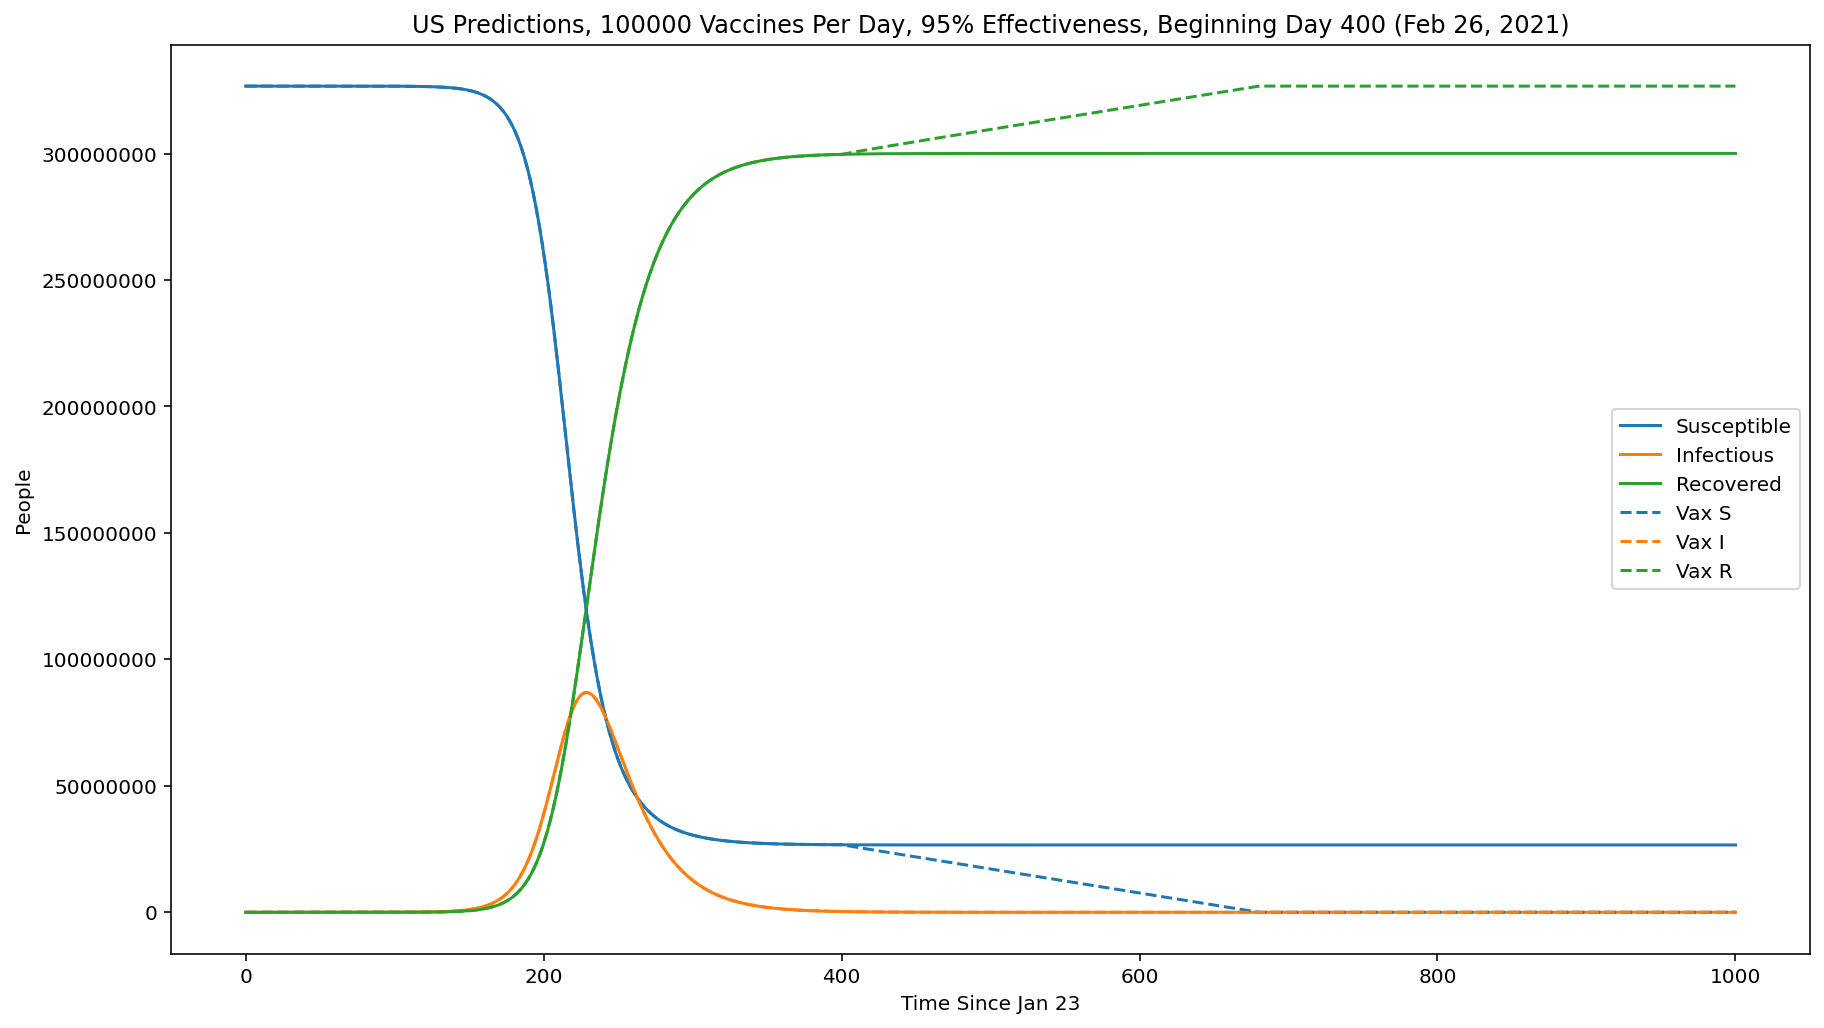

In [217]:
n = 1000
simulated, totalInfected = sirBasic(S0,I0,R0,x[0],x[1]/S0,n)

plt.plot(simulated[0,:],label='Susceptible')
plt.plot(simulated[1,:],label='Infectious')
plt.plot(simulated[2,:],label='Recovered')

# Reset the colors
plt.gca().set_prop_cycle(None)

plt.tight_layout()
plt.xlabel('Time Since Jan 23')
plt.ylabel('People')

# Plot the simulated data with vaccines
vaccines400, totalInfectedwithVaccinations, totalVaccinated = sirBasicVaccine(S0,I0,R0,x[0],x[1]/S0,n,100000,400,0.95)

plt.plot(vaccines400[0,:], '--', label='Vax S')
plt.plot(vaccines400[1,:], '--', label='Vax I')
plt.plot(vaccines400[2,:], '--', label='Vax R')

plt.title('US Predictions, 100000 Vaccines Per Day, 95% Effectiveness, Beginning Day 400 (Feb 26, 2021)')
plt.legend()

plt.ticklabel_format(style='plain')

print('Without vaccines,', totalInfected, ' people were infected')
print('With vaccines,', totalInfectedWithVaccinations, ' people were infected')
print(totalInfected - totalInfectedWithVaccinations, 'is the number of fewer cases with a total of', totalVaccinated, 'vaccines given')

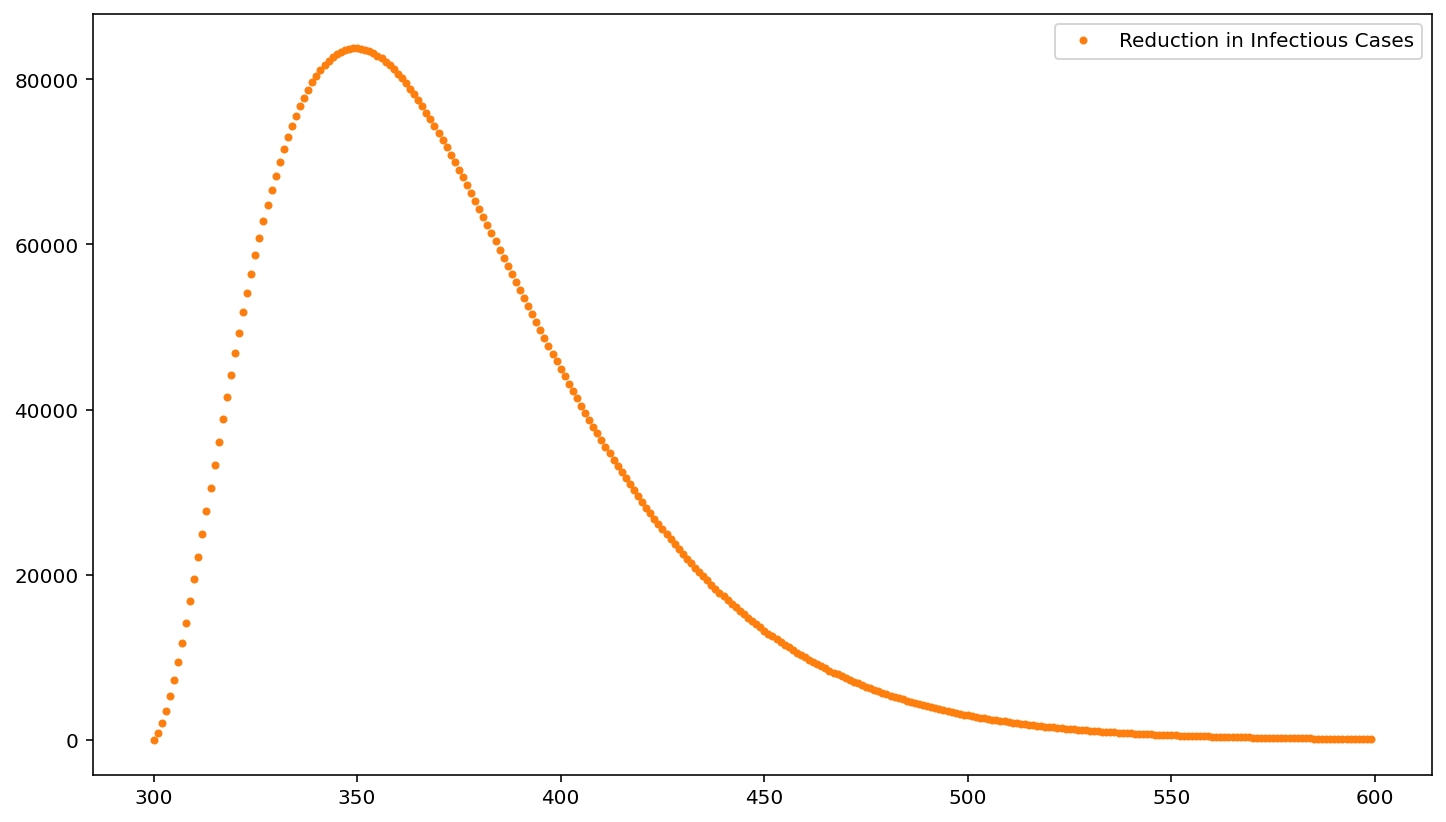

In [225]:
plt.plot(np.arange(300,600,1),simulated[1,303:603] - vaccines300[1,303:603], '.', color='tab:orange', label='Reduction in Infectious Cases')
#plt.plot(np.arange(300,600,1),simulated[1,303:603] - vaccines300[1,303:603], '.', color='tab:blue', label='Reduction in Infectious Cases')
plt.legend()